# Using Linear Models to Analyse Vector Abundance and Climate Data

In the face of global climate change, vector borne diseases have the capacity to shift ranges and drastically alter emergence times. This can have profound public health implications. Therefore, it is essential that we monitor, and make attempts to forecast how the changing climate could affect vectors. 

This notebook will demonstrate how to apply linear models to vector abundance data - specifically data that you can pull from the VecDyn database! 

Let's start off by reading in some packages which we will use later on in the example - but we can suppress the conflict messages using ```suppressMessages()```. 

In [1]:
suppressMessages(require(dplyr))
suppressMessages(require(tidyr))

Now, let's read in some data. There a couple of example datasets for you to explore - as well as a wealth of data you can download from the VecDyn database. They will all be in the same format, so the cleaning procedures, and the analytical processes will be the same for linear modelling. 

In [2]:
# This is a dataset from Walton County, Florida for the species Culex erraticus

Complete_data <- read.csv("../data/Culex_erraticus_walton.csv")

## Or you could use either of the following datasets for Culex nigripalpus

# Complete_data <- read.csv("../data/Culex_nigripalpus_walton.csv")
# Complete_data <- read.csv("../data/Culex_nigripalpus_manatee.csv")

Great, now we have some data. It's important that we have a look at it's layout.

In [3]:
head(Complete_data)

X,title,dataset_citation,publication_citation,description,url,contact_name,contact_affiliation,email,orcid,⋯,sample_sex,sample_stage,sample_location,sample_collection_area,sample_lat_dd,sample_long_dd,sample_environment,additional_location_info,additional_sample_info,sample_name
<int>,<fct>,<fct>,<lgl>,<fct>,<lgl>,<fct>,<lgl>,<lgl>,<lgl>,⋯,<fct>,<fct>,<fct>,<lgl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>
1622290,"Mosquito surveillance in South Walton County, Florida, USA. 2015","DOI:10.5281/zenodo.1220173,https://southwaltonmosquitocontrol.org/",NA,Mosquito surveillance from the South Walton County Mosquito Control District Vector Surveillance program to survey mosquito populations.,NA,Peter J Brabant;Peter J Brabant III,NA,NA,NA,⋯,female,adult,Walton County,NA,30.3813,-86.3593,NA,NA,NA,NA
1622343,"Mosquito surveillance in South Walton County, Florida, USA. 2015","DOI:10.5281/zenodo.1220173,https://southwaltonmosquitocontrol.org/",NA,Mosquito surveillance from the South Walton County Mosquito Control District Vector Surveillance program to survey mosquito populations.,NA,Peter J Brabant;Peter J Brabant III,NA,NA,NA,⋯,female,adult,Walton County,NA,30.3892,-86.0890,NA,NA,NA,NA
1622380,"Mosquito surveillance in South Walton County, Florida, USA. 2015","DOI:10.5281/zenodo.1220173,https://southwaltonmosquitocontrol.org/",NA,Mosquito surveillance from the South Walton County Mosquito Control District Vector Surveillance program to survey mosquito populations.,NA,Peter J Brabant;Peter J Brabant III,NA,NA,NA,⋯,female,adult,Walton County,NA,30.3469,-86.0694,NA,NA,NA,NA
1622410,"Mosquito surveillance in South Walton County, Florida, USA. 2015","DOI:10.5281/zenodo.1220173,https://southwaltonmosquitocontrol.org/",NA,Mosquito surveillance from the South Walton County Mosquito Control District Vector Surveillance program to survey mosquito populations.,NA,Peter J Brabant;Peter J Brabant III,NA,NA,NA,⋯,female,adult,Walton County,NA,30.3717,-86.2655,NA,NA,NA,NA
1622440,"Mosquito surveillance in South Walton County, Florida, USA. 2015","DOI:10.5281/zenodo.1220173,https://southwaltonmosquitocontrol.org/",NA,Mosquito surveillance from the South Walton County Mosquito Control District Vector Surveillance program to survey mosquito populations.,NA,Peter J Brabant;Peter J Brabant III,NA,NA,NA,⋯,female,adult,Walton County,NA,30.3650,-86.2261,NA,NA,NA,NA
1622479,"Mosquito surveillance in South Walton County, Florida, USA. 2015","DOI:10.5281/zenodo.1220173,https://southwaltonmosquitocontrol.org/",NA,Mosquito surveillance from the South Walton County Mosquito Control District Vector Surveillance program to survey mosquito populations.,NA,Peter J Brabant;Peter J Brabant III,NA,NA,NA,⋯,female,adult,Walton County,NA,30.3813,-86.3593,NA,NA,NA,NA


There's a lot of information in this dataset, most of which we won't be using to analyse the time series data. For simplicity, we should clean the data and store it in another data frame that we can use to map climate data to. 

In [4]:
# select only the rows of interest 
Main_data <- select(Complete_data, c("sample_end_date", "sample_value", "sample_lat_dd", "sample_long_dd"))

# Make sure the sample end date is in date format
Main_data$sample_end_date <- as.Date(Main_data$sample_end_date, format = "%Y-%m-%d")

# Order by date 
Main_data <- Main_data[order(Main_data$sample_end_date, decreasing=FALSE),]

# We can now create columns for Month/Year and Month 
Main_data$Month_Yr <- format(as.Date(Main_data$sample_end_date), "%Y-%m")
Main_data$Month <- format(as.Date(Main_data$sample_end_date), "%m")

# Many sample values are returned with zeros which will cause problems once we log the abundance data 
# So, we can transform this data by scaling up by 0.00001 
Main_data$sample_value <- Main_data$sample_value + 0.00001

# Remove all zeros (on the slight off chance there are some)
Main_data<-subset(Main_data, Main_data$sample_value>0)

# create a log column - we could also use a log(x+1) transform rather than + 0.00001
Main_data$log_sample <- log(Main_data$sample_value)

# Pre-allocate the rows for climate data by filling with NAs
Main_data$Max.Temp <- NA
Main_data$Precipitation <- NA


# Import and Map Climate Data 


Next, we can import the climate data to be matched up to the abundance data we have stored as ```Main_data```. For this, you will need to ensure you have the climate data file "vectorbase_locations_dates_climate.csv" saved in your data directory. 

This climate data has been downloaded in advance from NOAA databases, on a scale of 2.5x2.5 degrees lat/long, on a daily basis. 


In [5]:
# Read in the climate data csv 

Climate_data <- read.csv("../data/vectorbase_locations_dates_climate.csv")


We can now populate these columns by matching up the date for each row, and the closest co-ordinates we have in our climate data. 


In [6]:
# For each row in Main_data
for (row in 1:nrow(Main_data)){

  # extract the date associated with the row 
  date <- as.character(Main_data[row, "sample_end_date"])
  
  # subset the climate data to only those with the same date
  data <- subset(Climate_data, Climate_data$Collection.date.range == date)
  
  if (nrow(data)>0){
  
    # define the lat and long desired
    lat <- as.numeric(Main_data[row, "sample_lat_dd"])
    long <- as.numeric(Main_data[row, "sample_long_dd"])
    
    # find the absolute differences between desired lat/longs to the climate datasets
    x <- abs(data$Initial_latitude - lat)
    y <- abs(data$Initial_longitude - long)
    
    # find the index for which there is the minimum overall difference between lat/longs 
    z<-which(x+y==min(x+y))
    
    # draw out the max temp and place into main data frame 
    Main_data[row, "Max.Temp"] <- data[z, "Max.Temp"]
    Main_data[row, "Precipitation"] <- data[z, "Precipitation"]
    
  }
  
  else{
  
    # If there arent any data to extract for a given date, input NAs
    Main_data[row, "Max.Temp"] <- NA
    Main_data[row, "Precipitation"] <- NA
  }
  
}


Now let's check whether this has worked correctly, and assess whether there are any ```NA```'s. 

In [7]:
summary(Main_data$Max.Temp)
summary(Main_data$Precipitation)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  9.656  23.902  27.844  26.895  31.091  35.782 

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
  0.00000   0.00000   0.02836   5.73650   4.60330 121.88240 

When considering time series data, the temporal resolution can have profound implications. Ideally, we want no gaps in our data - therefore working with data on the daily scale for abundance data appears implausible. 

Therefore, we will aggregate our data to the monthly scale on an average. 

In [8]:
Aggregated_data <- aggregate(cbind(sample_value, Max.Temp, Precipitation, log_sample) ~ Month_Yr, data = Main_data, mean)
print(Aggregated_data)

   Month_Yr sample_value Max.Temp Precipitation log_sample
1   2015-01  0.000010000 17.74602   3.303991888 -11.512925
2   2015-02  0.018191818 17.87269  16.544265802 -11.303599
3   2015-03  0.468095106 23.81767   2.405651215  -9.735164
4   2015-04  1.619057619 26.03559   8.974406168  -7.671132
5   2015-05  0.821438571 30.01602   0.567960943  -8.722485
6   2015-06  3.005962381 31.12094   4.841342729  -4.914463
7   2015-07  2.380962381 32.81130   3.849010353  -7.056628
8   2015-08  1.826357305 32.56245   5.562845324  -6.782594
9   2015-09  0.648819524 30.55155  10.409724627  -8.453458
10  2015-10  0.988033952 27.22605   0.337750269  -8.499736
11  2015-11  0.737814878 24.86768  18.306749680 -10.077454
12  2015-12  0.142867143 22.46588   5.621475377 -11.207513
13  2016-01  0.000010000 16.02406   3.550622029 -11.512925
14  2016-02  0.020212020 19.42057  11.254680803 -11.334986
15  2016-03  0.015161515 23.13610   4.785664728 -11.338487
16  2016-04  0.026153791 24.98082   4.580424519 -11.3552

Now that we have a clean dataframe to work with, let's plot our abundance data. 

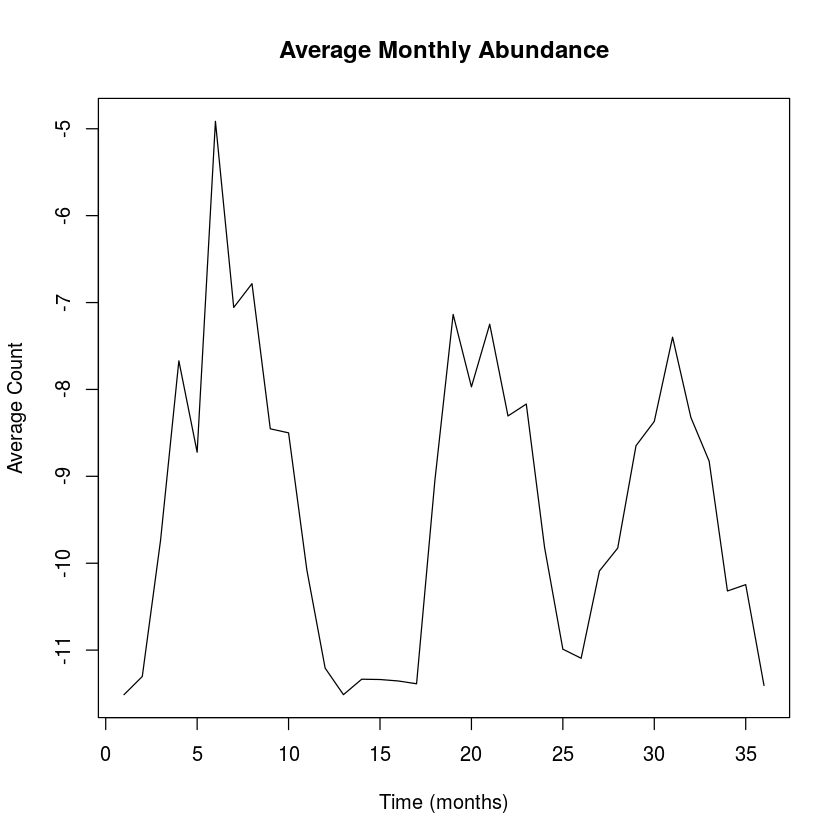

In [9]:
plot(Aggregated_data$log_sample, type = "l", main="Average Monthly Abundance", xlab ="Time (months)", ylab = "Average Count")

# Applying Linear Models 





In [10]:

# create a dataframe containing covariates 

t <- 2:nrow(Aggregated_data)
TS_df <- data.frame(Specimens=Aggregated_data$log_sample[2:nrow(Aggregated_data)],
                        SpecimensPast=Aggregated_data$log_sample[1:nrow(Aggregated_data)-1],
                        t=t,
                        Month=Aggregated_data$Month[2:nrow(Aggregated_data)],
                        Max.Temp=Aggregated_data$Max.Temp[2:nrow(Aggregated_data)],
                        Precipitation=Aggregated_data$Precipitation[2:nrow(Aggregated_data)],
                        sin12=sin(2*pi*t/12), cos12=cos(2*pi*t/12))



Here we will conduct and plot a number of linear regression models for our data we will progressively add components to see which best predicts the data given. 


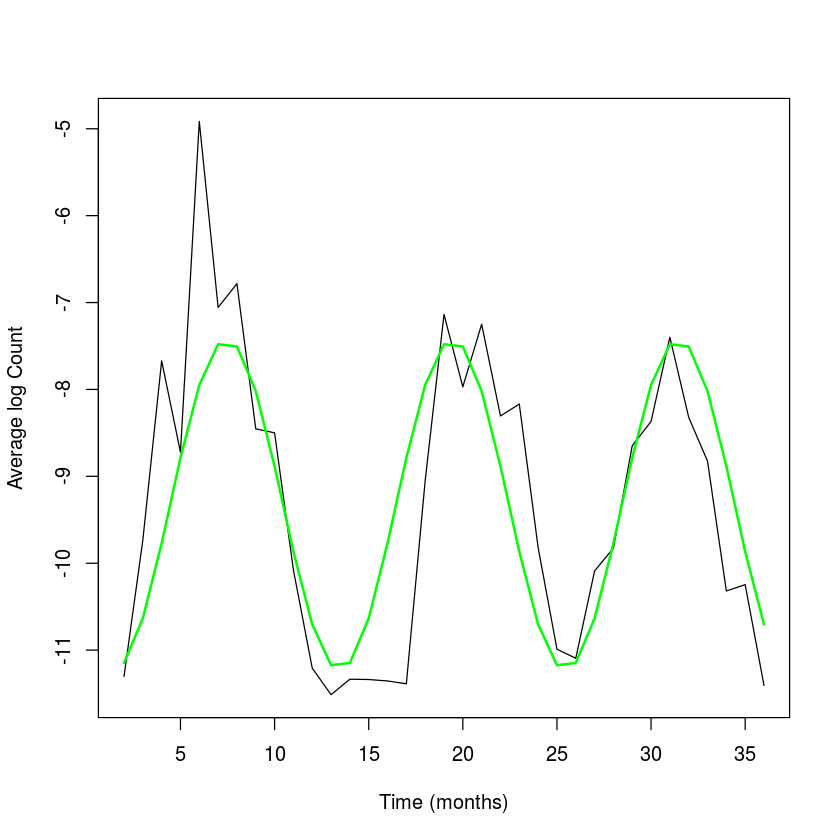

In [11]:

# plot the log sample 
par(mfrow=c(1,1))
plot(t, TS_df$Specimens, type="l", xlab = "Time (months)", ylab = "Average log Count")

# create a vector to store the adjusted R squared for each model 
adj.R2 <- vector()


# first we will look at how the previous time step and the time itself can predict

TS_lm_sin_cos <- lm(Specimens ~ sin12 + cos12, data = TS_df)
#summary(TS_lm_temp)
# add a line to the plot for this particular model 
lines(t, TS_lm_sin_cos$fitted, col="green", lwd=2)
# we will store the R2 for later, so that we can make direct comparisons 
adj.R2 <- c(adj.R2, summary(TS_lm_sin_cos)$adj.r.squared)

It looks like the sine and cosine waves can predict the peaks relatively well! 

One consideration to make when conducting time series analysis, is whether the data is autocorrelated. With a lag time, does the data appear to correlate with itself? We can check using the ```acf()``` function in R:

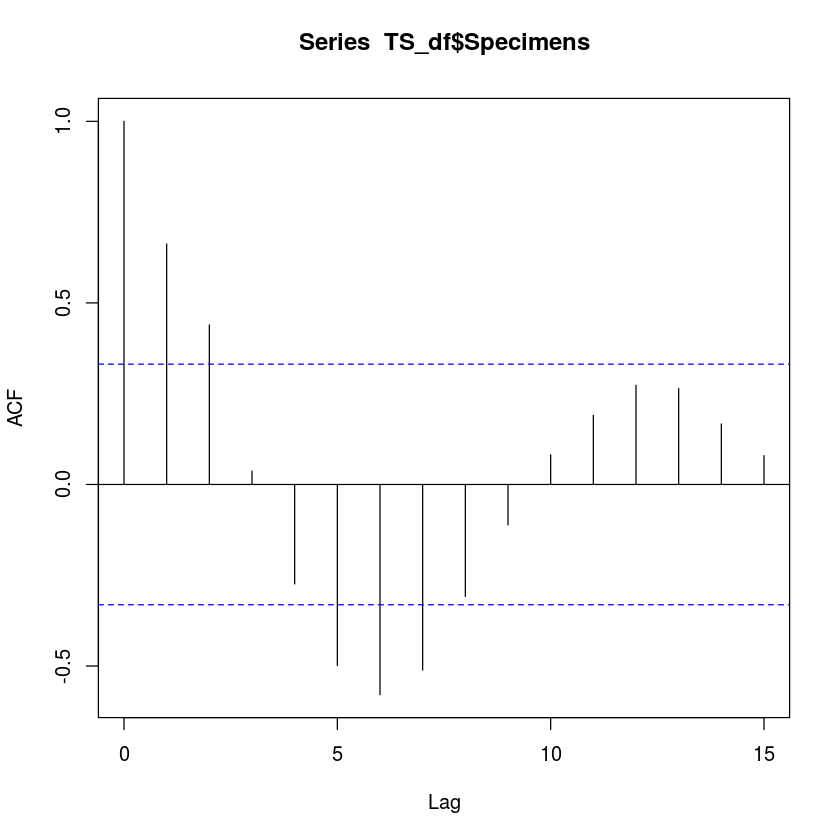

In [12]:
acf(TS_df$Specimens)

The ```acf()``` function automatically includes a 0 time lag as a reference point with a score of 1. We can see that a single time lag is most correlated, so it would be interesting to incorporate this into a linear model. 

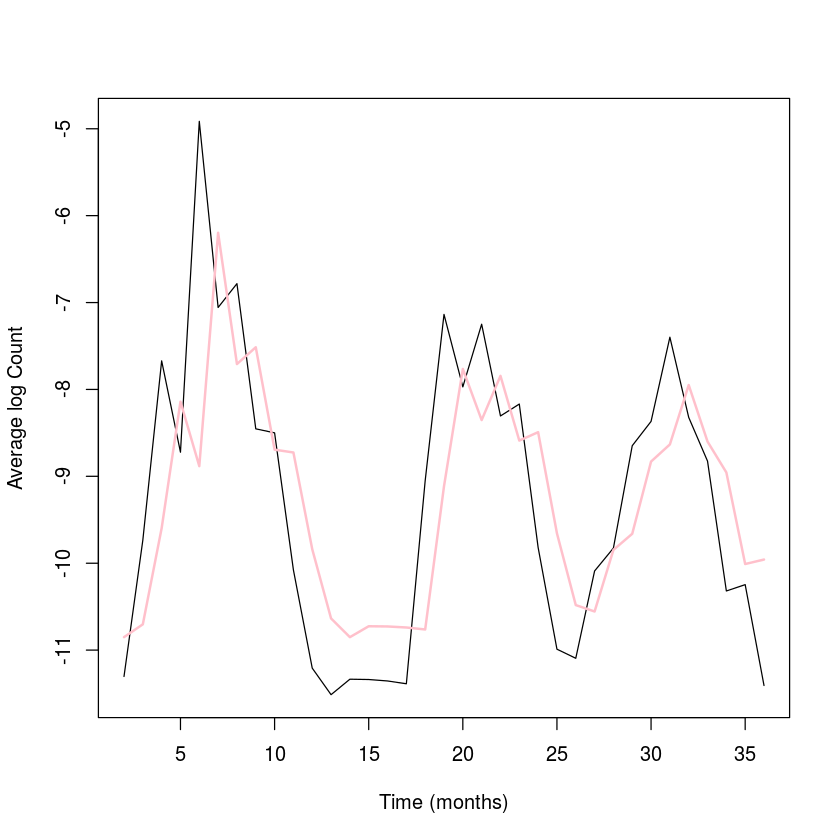

In [13]:
TS_lm <- lm(Specimens ~ SpecimensPast, data = TS_df)
#summary(TS_lm)
plot(t, TS_df$Specimens, type="l", xlab = "Time (months)", ylab = "Average log Count")
lines(t, TS_lm$fitted, col="pink", lwd=2)
adj.R2 <- c(adj.R2, summary(TS_lm)$adj.r.squared)


Next, we can create a model to incorporate climatic factors individually into our models:

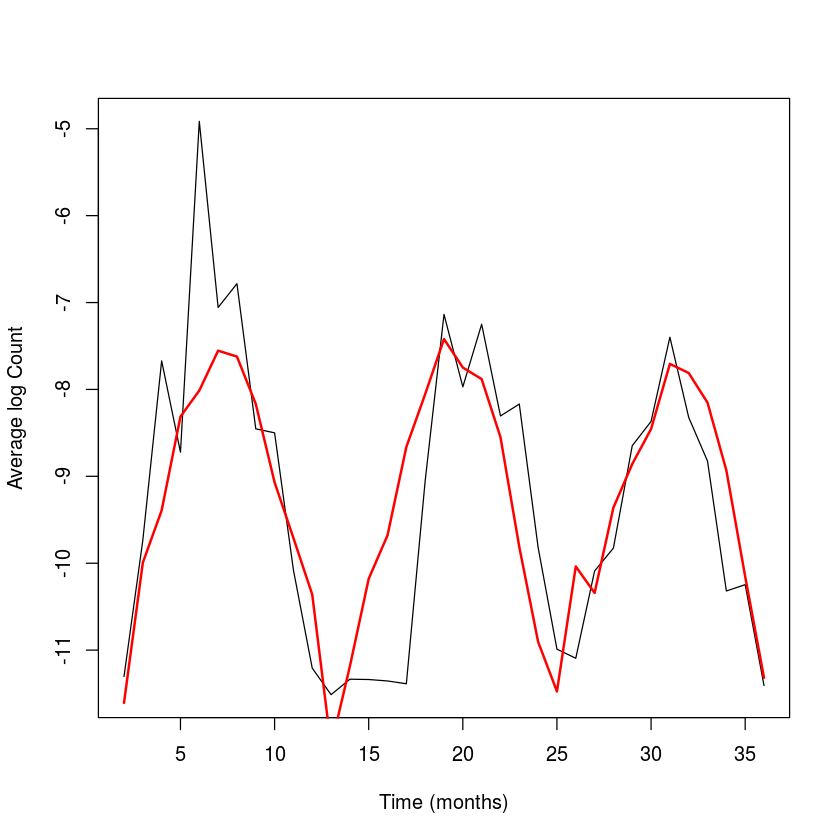

In [14]:
TS_lm_temp <- lm(Specimens ~ Max.Temp, data = TS_df)
#summary(TS_lm_temp)
plot(t, TS_df$Specimens, type="l", xlab = "Time (months)", ylab = "Average log Count")
lines(t, TS_lm_temp$fitted, col="red", lwd=2)
adj.R2 <- c(adj.R2, summary(TS_lm_temp)$adj.r.squared)


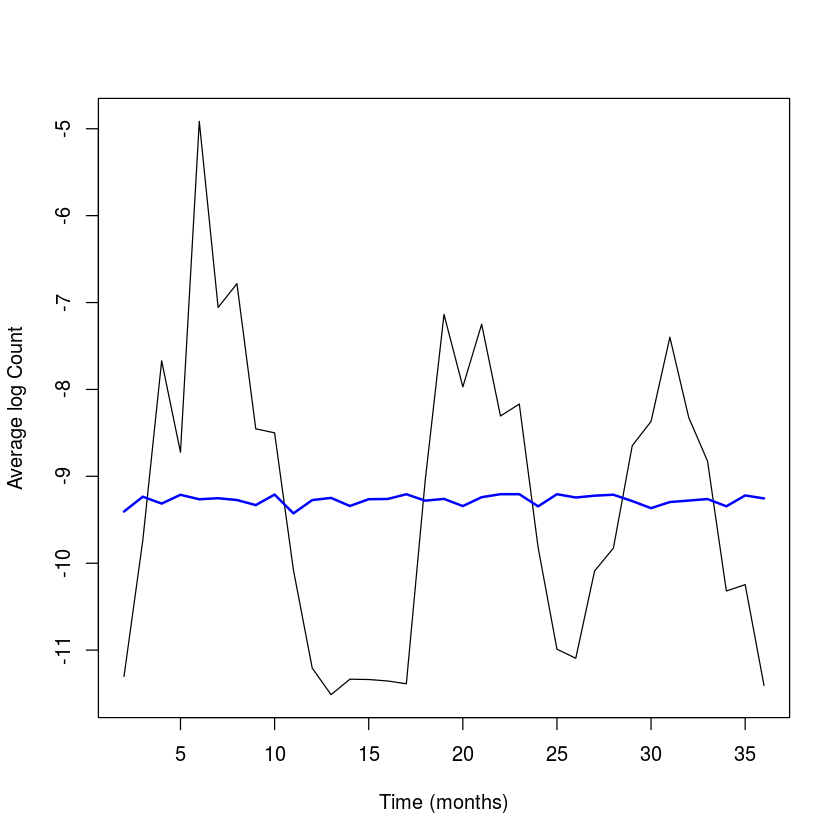

In [15]:
TS_lm_precip <- lm(Specimens ~ Precipitation, data = TS_df)
#summary(TS_lm_precip)
plot(t, TS_df$Specimens, type="l", xlab = "Time (months)", ylab = "Average log Count")
lines(t, TS_lm_precip$fitted, col="blue", lwd=2)
adj.R2 <- c(adj.R2, summary(TS_lm_precip)$adj.r.squared)


Finally, let's incorporate all of our factors into one model.

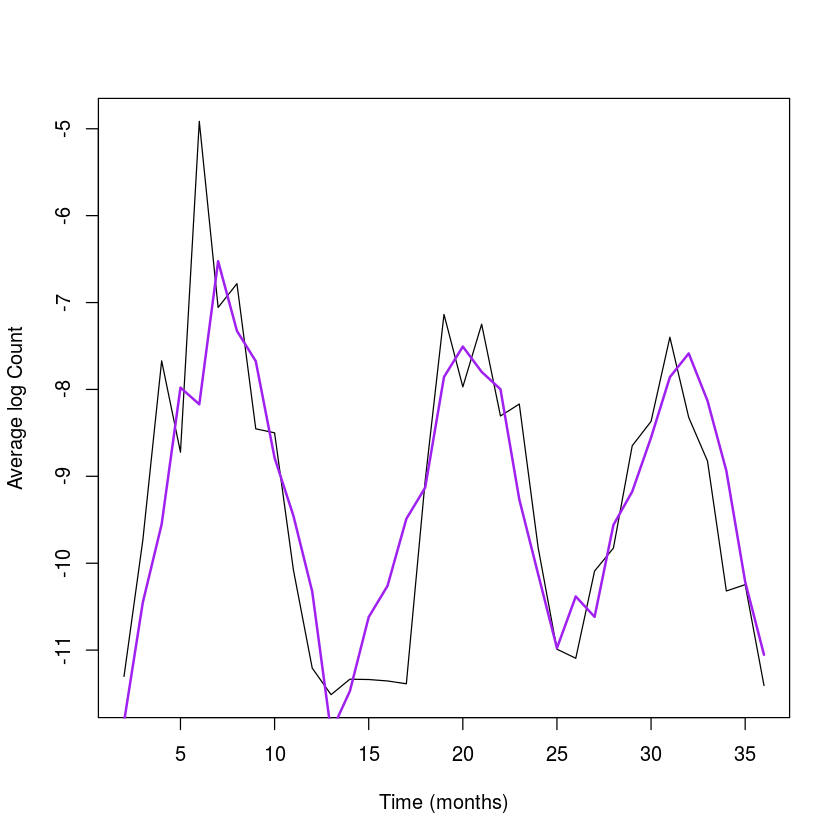

In [16]:
TS_lm_all <- lm(Specimens ~ SpecimensPast + Max.Temp + Precipitation, data = TS_df)
#summary(TS_lm_all)
plot(t, TS_df$Specimens, type="l", xlab = "Time (months)", ylab = "Average log Count")
lines(t, TS_lm_all$fitted, col="purple", lwd=2)
adj.R2 <- c(adj.R2, summary(TS_lm_all)$adj.r.squared)


All of the models appear, visually, to predict our data relatively well except precipitation. We can compare our models by looking at the $R^2$ value adjusted for the number of free parameters included. Remember that the $R^2$ value shows us the proportion of our data that can be explained by our model. 

In [17]:
# now let's have a look at how each model performed comparitively 
print(adj.R2)

[1]  0.60466498  0.48464800  0.61071860 -0.02908796  0.66016006


# Model Comparison 

Now that we have our models, we can make comparisons between them using a partial F test and/or BIC (Bayesian Information Criterion) analysis.

We have had a look at our $R^2$ values, but we should also look to compare them using a partial F-test. This can be applied to models that are nested - for instance the temperature model and the complete model. 



In [18]:
anova(TS_lm_temp, TS_lm_all)

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
33,36.96753,NA,NA,NA,NA
31,30.31649,2,6.651037,3.400495,0.04621756


Now consider using BIC analysis. Generally, the lowest BIC value is the preferred model. A difference of greater than 2 shows evidence against the higher scored model, whilst a difference of greater than 10 showing strong evidence. 

You may choose to compare any of the models, but here I will compare the sin/cos model with the complete (all) model. 

In [19]:
# define the length of the series 
n<-length(TS_df$Specimens)-1

# extract the BIC scores 
bics<-c(TS_mod_sin_cos=extractAIC(TS_lm_sin_cos, k=log(n))[2],TS_mod_all=extractAIC(TS_lm_all, k=log(n))[2])

# subtract the bic scores 
as.numeric(bics[1]) - as.numeric(bics[2])


[1] 2.878902

For this example using Culex erraticus from Walton County, we can see that there is positive evidence for the complete model incorporating Precipitation, Maximum Temperature and past specimen counts with a BIC score that is 2.88 lower than the sin/cos model. 